# 🩺 Day 3 - AI-Based Dibates Diagnosis
### Medical Diagnosis Feature Importance Analysis using Permutation Importance & SHAP
This project uses SHAP and Permutation Feature Importance to interpret a Random Forest diabetes prediction model, identifying Glucose, BMI, and Age as the most influential risk factors.


## 1. Importing Libraries

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import filedialpy as fp
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings
import time

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix

# Explainability
import shap

# Color Palette and configuration
palette = ['#edafb8', '#dedbd2', '#b0c4b1', '#4a5759']
sns.set_palette(palette)
sns.set(rc={"axes.facecolor":"#f7e1d7","figure.facecolor":"#f5f5f5"})
cmap = colors.ListedColormap(palette)
%matplotlib inline
warnings.filterwarnings('ignore')


print('All imports successful and configurations set!')

All imports successful and configurations set!


---

## 2. Data Loading and Initial Exploration

Before proceeding with model development, it is essential to **load and explore the dataset** to gain a clear understanding of its structure and quality.  
This phase includes importing the data, examining its dimensions and data types, identifying missing or inconsistent values, and analyzing key descriptive statistics.  
A thorough initial exploration ensures that the dataset is **accurate, consistent, and well-prepared** for subsequent preprocessing and predictive modeling steps.


#### Load the Dataset

In [7]:
df = pd.read_csv(fp.openFile())
print('Data Loaded!')
df.head()

Data Loaded!


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### Dataset Shape

In [9]:
df.shape

(768, 9)

#### Dataset Information

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


#### Statistical Summary

In [13]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### Missing Values

In [15]:
print(df.isnull().sum().sum(), "missing values found.")

0 missing values found.


#### Class Balance

In [17]:
df['Outcome'].value_counts(normalize=True).to_dict()

{0: 0.6510416666666666, 1: 0.3489583333333333}

---

## 3. Data Preparation

In [20]:
# Prepare data
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                   'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

X = df[feature_columns]
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train.shape}\nTest: {X_test.shape}")

Train: (614, 8)
Test: (154, 8)


---

## 4. Model Training - Logistic Regression, Random Forest, XGBoosst

In [23]:
# Train models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}

results = {}
for name, model in models.items():
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_proba),
        'F1': f1_score(y_test, y_pred)
    }
    print(f"{name}:\nAcc={results[name]['Accuracy']:.3f}\nAUC={results[name]['AUC']:.3f}\n---------------------------")

print("All models trained!")

Logistic Regression:
Acc=0.714
AUC=0.823
---------------------------
Random Forest:
Acc=0.760
AUC=0.812
---------------------------
XGBoost:
Acc=0.734
AUC=0.805
---------------------------
All models trained!


---

## 5. SHAP Analysis

SHAP computation time: 0.26 seconds


<Figure size 1000x600 with 0 Axes>

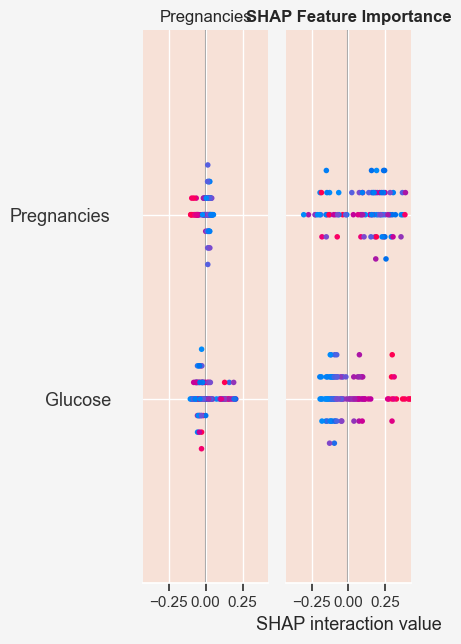

In [26]:
# SHAP for Random Forest (representative model)
model_rf = models['Random Forest']
X_test_sample = X_test.iloc[:100]

start_time = time.time()
explainer_shap = shap.TreeExplainer(model_rf)
shap_values = explainer_shap.shap_values(X_test_sample)
if isinstance(shap_values, list):
    shap_values = shap_values[1]
shap_time = time.time() - start_time

print(f"SHAP computation time: {shap_time:.2f} seconds")

# SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title('SHAP Feature Importance', fontweight='bold')
plt.tight_layout()
plt.show()

In [27]:
# SHAP global feature importance
shap_importance = np.mean(np.abs(shap_values), axis=(0, 2))  # take mean over samples and classes

shap_df = pd.DataFrame({
    'Feature': feature_columns,
    'SHAP Importance': shap_importance
}).sort_values('SHAP Importance', ascending=False)

print("\nSHAP Global Feature Ranking:")
print(shap_df.to_string(index=False))


SHAP Global Feature Ranking:
                 Feature  SHAP Importance
                 Glucose         0.127233
                     BMI         0.070513
                     Age         0.059261
DiabetesPedigreeFunction         0.042351
             Pregnancies         0.031520
                 Insulin         0.018886
           SkinThickness         0.016911
           BloodPressure         0.016401


---

## 6. Permutation Importance



🔍 Calculating Permutation Importance...
Permutation Importance computation time: 0.65 seconds


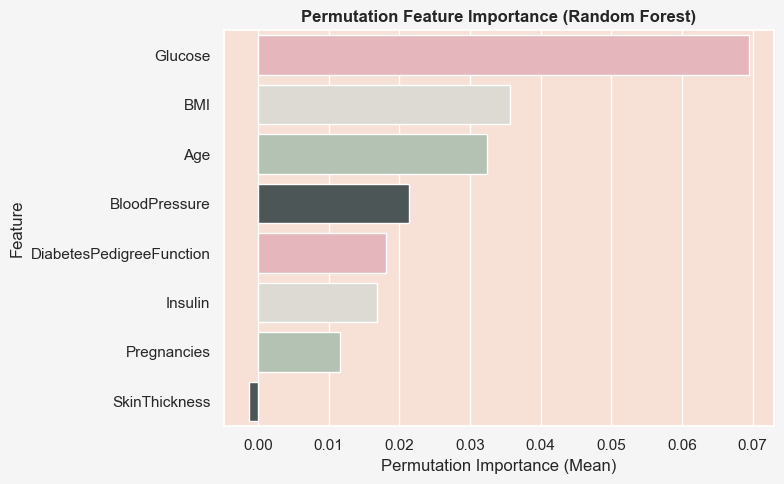


Permutation Importance Ranking:
                 Feature  Permutation Importance (Mean)  Permutation Importance (Std)
                 Glucose                       0.069481                      0.025158
                     BMI                       0.035714                      0.018876
                     Age                       0.032468                      0.016169
           BloodPressure                       0.021429                      0.010081
DiabetesPedigreeFunction                       0.018182                      0.009091
                 Insulin                       0.016883                      0.008316
             Pregnancies                       0.011688                      0.012922
           SkinThickness                      -0.001299                      0.011543


In [30]:
# ---------------------------------------------------------------
# 🧩 Permutation Importance
# ---------------------------------------------------------------
from sklearn.inspection import permutation_importance

print("\n🔍 Calculating Permutation Importance...")
perm_start = time.time()

# Use Random Forest for this example
result = permutation_importance(model_rf, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

perm_time = time.time() - perm_start
print(f"Permutation Importance computation time: {perm_time:.2f} seconds")

# Create a dataframe
perm_df = pd.DataFrame({
    'Feature': feature_columns,
    'Permutation Importance (Mean)': result.importances_mean,
    'Permutation Importance (Std)': result.importances_std
}).sort_values('Permutation Importance (Mean)', ascending=False)

# Plot Permutation Importance
plt.figure(figsize=(8, 5))
sns.barplot(x='Permutation Importance (Mean)', y='Feature', data=perm_df, orient='h', palette=palette)
plt.title('Permutation Feature Importance (Random Forest)', fontweight='bold')
plt.tight_layout()
plt.show()

print("\nPermutation Importance Ranking:")
print(perm_df.to_string(index=False))

---

## 7. SHAP (global + dependence + local)

<Figure size 900x600 with 0 Axes>

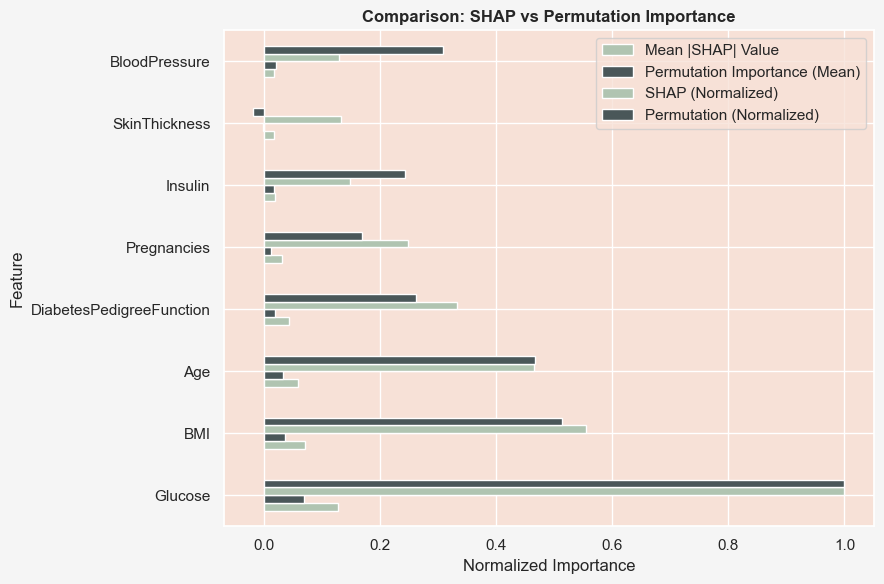


Combined Feature Importance Comparison:
                 Feature  Mean |SHAP| Value  Permutation Importance (Mean)
                 Glucose           0.127233                       0.069481
                     BMI           0.070513                       0.035714
                     Age           0.059261                       0.032468
DiabetesPedigreeFunction           0.042351                       0.018182
             Pregnancies           0.031520                       0.011688
                 Insulin           0.018886                       0.016883
           SkinThickness           0.016911                      -0.001299
           BloodPressure           0.016401                       0.021429


In [33]:
# ---------------------------------------------------------------
# 📊 Compare SHAP vs Permutation Importance
# ---------------------------------------------------------------

# Merge results for comparison
compare_df = pd.merge(
    shap_df.rename(columns={'SHAP Importance': 'Mean |SHAP| Value'}),
    perm_df[['Feature', 'Permutation Importance (Mean)']],
    on='Feature'
)

# Normalize values for fair comparison
compare_df['SHAP (Normalized)'] = compare_df['Mean |SHAP| Value'] / compare_df['Mean |SHAP| Value'].max()
compare_df['Permutation (Normalized)'] = compare_df['Permutation Importance (Mean)'] / compare_df['Permutation Importance (Mean)'].max()

# Plot comparison
plt.figure(figsize=(9, 6))
compare_df.plot(x='Feature', kind='barh', 
                stacked=False, color=['#b0c4b1', '#4a5759'], 
                figsize=(9,6))
plt.title("Comparison: SHAP vs Permutation Importance", fontweight='bold')
plt.xlabel("Normalized Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print("\nCombined Feature Importance Comparison:")
print(compare_df[['Feature', 'Mean |SHAP| Value', 'Permutation Importance (Mean)']].to_string(index=False))


---

## 8. Conslusion

In [36]:
# ---------------------------------------------------------------
# 🏁 Final Summary
# ---------------------------------------------------------------
top_shap = shap_df.iloc[0]
top_perm = perm_df.iloc[0]

print("🏁 FINAL INSIGHTS")
print("------------------------------------------------------------")
print(f"Most Influential Feature (SHAP): {top_shap['Feature']} ({top_shap['SHAP Importance']:.4f})")
print(f"Most Influential Feature (Permutation): {top_perm['Feature']} ({top_perm['Permutation Importance (Mean)']:.4f})")
print("------------------------------------------------------------")

print("💡 Interpretation:")
print("- SHAP explains how each feature contributes to individual predictions.")
print("- Permutation Importance explains how each feature affects overall model accuracy.")
print("- Comparing both helps validate which medical factors consistently impact diabetes diagnosis.")


🏁 FINAL INSIGHTS
------------------------------------------------------------
Most Influential Feature (SHAP): Glucose (0.1272)
Most Influential Feature (Permutation): Glucose (0.0695)
------------------------------------------------------------
💡 Interpretation:
- SHAP explains how each feature contributes to individual predictions.
- Permutation Importance explains how each feature affects overall model accuracy.
- Comparing both helps validate which medical factors consistently impact diabetes diagnosis.
